In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/cleaned_responses.csv")

print("Original dataset shape:", df.shape)
print(df['diabetes_diagnosed'].value_counts())
print(f"Diabetes prevalence: {(df['diabetes_diagnosed'].sum() / len(df)) * 100:.2f}%")


Original dataset shape: (314, 14)
diabetes_diagnosed
0    211
1    103
Name: count, dtype: int64
Diabetes prevalence: 32.80%


In [2]:
# Feature selection and preparation

feature_cols = ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 
                'weight', 'height', 'insulin', 'bmi', 'physically_active', 
                'smoking', 'junk_food', 'family_history']

X = df[feature_cols].copy()
y = df['diabetes_diagnosed'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_cols}")

# Check correlation with target variable
print("\nCorrelation with target variable:")
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)


Feature matrix shape: (314, 13)
Features used: ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 'weight', 'height', 'insulin', 'bmi', 'physically_active', 'smoking', 'junk_food', 'family_history']

Correlation with target variable:
blood_pressure       0.802786
age                  0.713982
glucose              0.568363
weight               0.559851
height               0.341301
family_history       0.334295
smoking              0.295420
pregnancies          0.272878
bmi                  0.230439
physically_active    0.110218
gender               0.078578
insulin              0.001255
junk_food           -0.052927
dtype: float64


In [3]:
# Data preparation and train-test split

complete_data = df[feature_cols + ['diabetes_diagnosed']].dropna()

X = complete_data[feature_cols].copy()
y = complete_data['diabetes_diagnosed'].copy()

print(f"Final feature matrix shape: {X.shape}")
print(f"Missing values in final dataset: {X.isnull().sum().sum()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"Training set diabetes prevalence: {(y_train.sum() / len(y_train)) * 100:.2f}%")

print(f"\nTest set target distribution:")
print(y_test.value_counts())
print(f"Test set diabetes prevalence: {(y_test.sum() / len(y_test)) * 100:.2f}%")


Final feature matrix shape: (314, 13)
Missing values in final dataset: 0

Training set target distribution:
diabetes_diagnosed
0    169
1     82
Name: count, dtype: int64
Training set diabetes prevalence: 32.67%

Test set target distribution:
diabetes_diagnosed
0    42
1    21
Name: count, dtype: int64
Test set diabetes prevalence: 33.33%


In [4]:
# Gradient Boosting Machine Model Training

print("Starting Gradient Boosting Machine hyperparameter tuning...")

# Optimized parameter grid for GBM 
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gbm = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(
    gbm, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
)

print("Fitting GBM models with different parameter combinations:")
grid_search.fit(X_train, y_train)  

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

print("\nTraining final GBM model with best parameters:")
best_gbm = grid_search.best_estimator_
best_gbm.fit(X_train, y_train)
print("GBM model training completed!")


Starting Gradient Boosting Machine hyperparameter tuning...
Fitting GBM models with different parameter combinations:
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.9697

Training final GBM model with best parameters:
GBM model training completed!


In [5]:
# Model Evaluation

y_pred = best_gbm.predict(X_test)
y_pred_proba = best_gbm.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nGBM Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\nCross-validation scores:")
cv_scores = cross_val_score(best_gbm, X_train, y_train, cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



GBM Model Performance Metrics:
Accuracy: 0.9841
Precision: 1.0000
Recall: 0.9524
F1-Score: 0.9756
AUC-ROC: 0.9694

Confusion Matrix:
[[42  0]
 [ 1 20]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.95      0.98        21

    accuracy                           0.98        63
   macro avg       0.99      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63


Cross-validation scores:
CV F1-Score: 0.9697 (+/- 0.0396)



Feature Importance (GBM):
              feature  importance
2                 age    0.258818
4      blood_pressure    0.215253
3             glucose    0.212850
5              weight    0.155664
7             insulin    0.054674
8                 bmi    0.045367
9   physically_active    0.016229
12     family_history    0.014406
6              height    0.013201
1         pregnancies    0.011107
0              gender    0.001266
11          junk_food    0.001032
10            smoking    0.000133


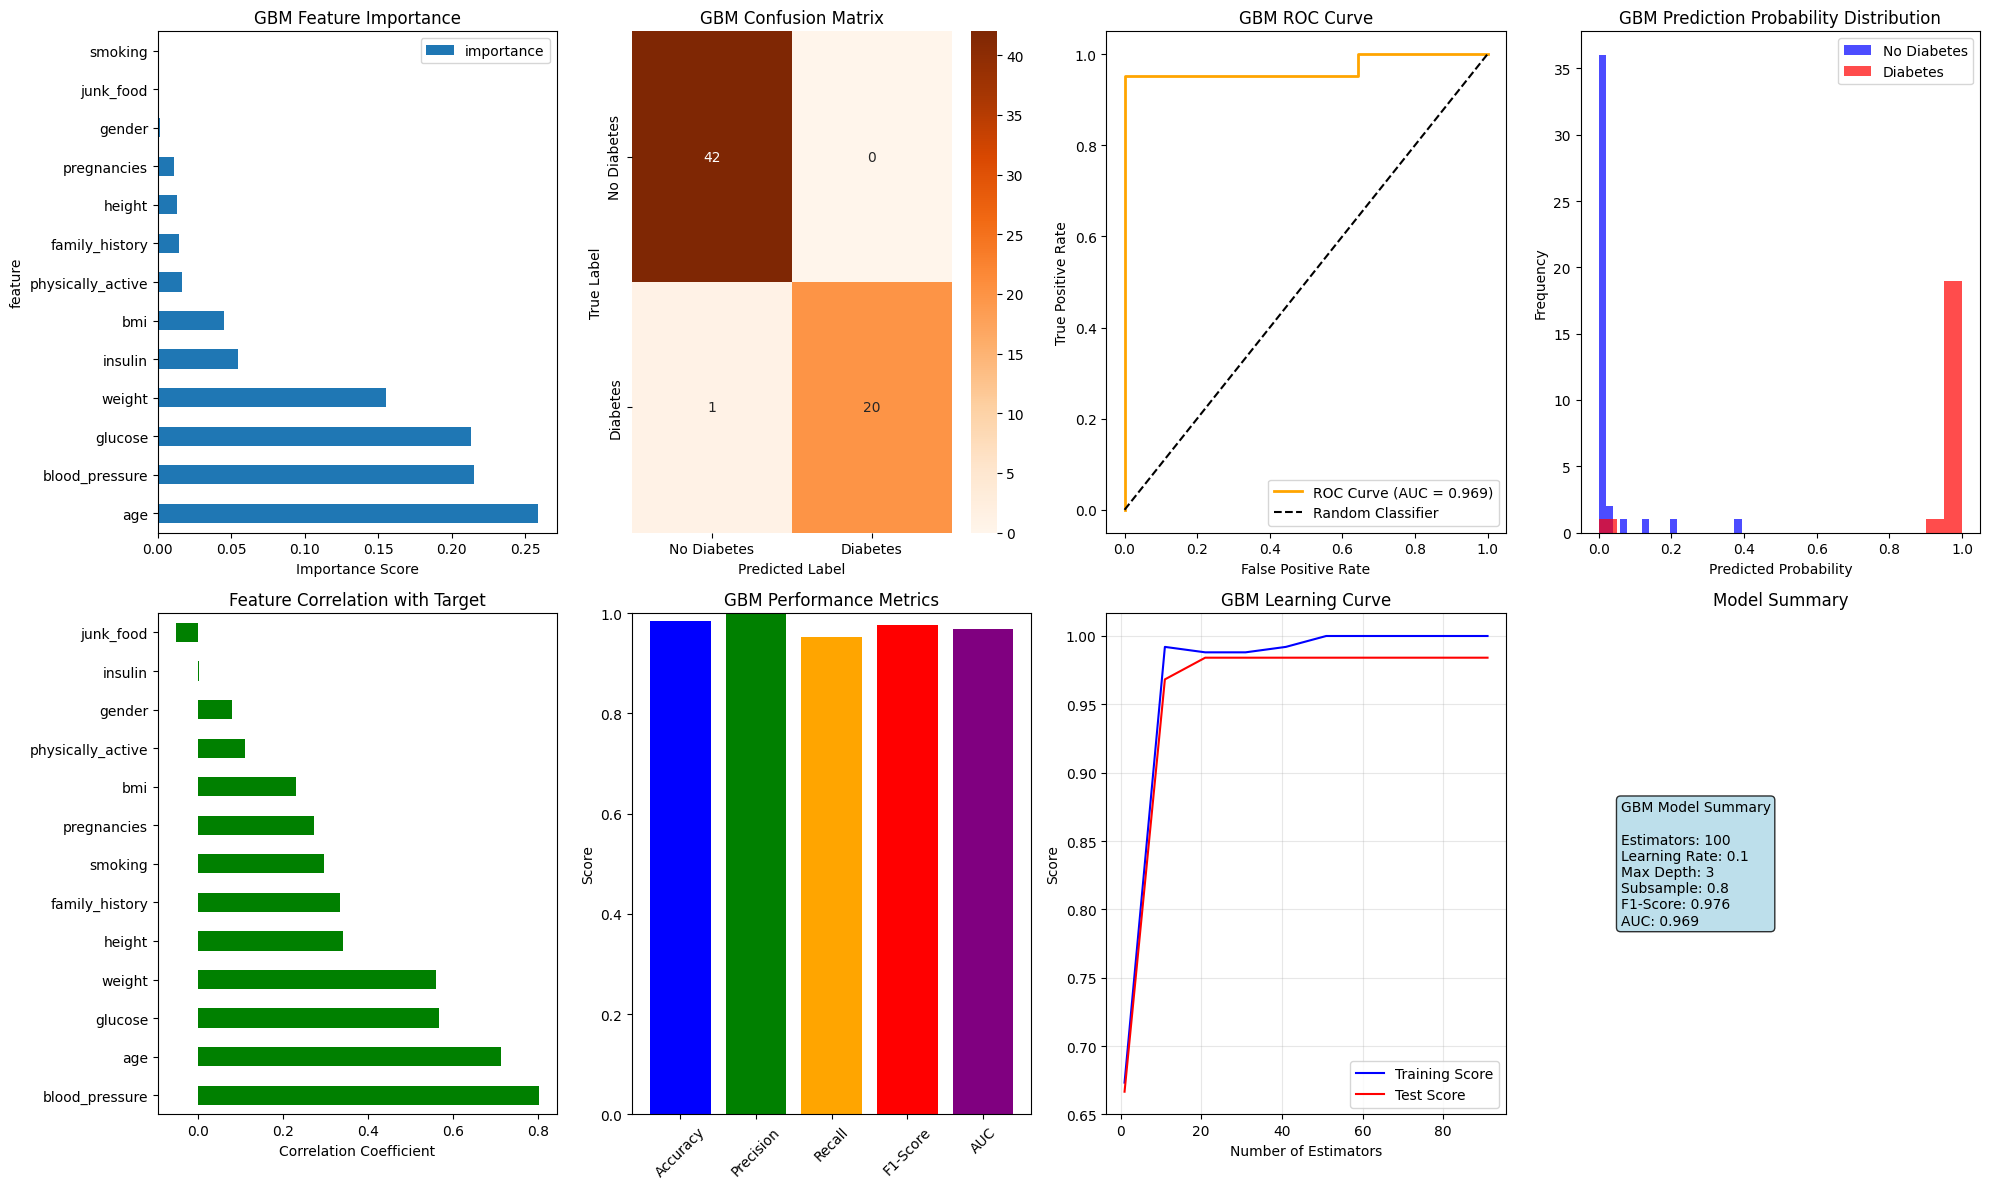

In [7]:
# Feature Importance Analysis and Learning Curves

# Get feature importance from GBM
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_gbm.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance (GBM):")
print(feature_importance)

# Get training scores for learning curve
train_scores = []
test_scores = []
n_estimators_range = range(1, best_gbm.n_estimators + 1, 10)

for n_est in n_estimators_range:
    gbm_temp = GradientBoostingClassifier(
        n_estimators=n_est,
        learning_rate=best_gbm.learning_rate,
        max_depth=best_gbm.max_depth,
        min_samples_split=best_gbm.min_samples_split,
        min_samples_leaf=best_gbm.min_samples_leaf,
        subsample=best_gbm.subsample,
        max_features=best_gbm.max_features,
        random_state=42
    )
    gbm_temp.fit(X_train, y_train)
    train_scores.append(gbm_temp.score(X_train, y_train))
    test_scores.append(gbm_temp.score(X_test, y_test))

plt.figure(figsize=(20, 12))

# 1. Feature Importance Plot
plt.subplot(2, 4, 1)
feature_importance.plot(x='feature', y='importance', kind='barh', ax=plt.gca())
plt.title('GBM Feature Importance')
plt.xlabel('Importance Score')

# 2. Confusion Matrix Heatmap
plt.subplot(2, 4, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('GBM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. ROC Curve
plt.subplot(2, 4, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='orange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GBM ROC Curve')
plt.legend()

# 4. Prediction Probability Distribution
plt.subplot(2, 4, 4)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Diabetes', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Diabetes', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('GBM Prediction Probability Distribution')
plt.legend()

# 5. Feature Correlation with Target
plt.subplot(2, 4, 5)
correlations.plot(kind='barh', color='green')
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation Coefficient')

# 6. Model Performance Summary
plt.subplot(2, 4, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, auc]
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.bar(metrics, values, color=colors)
plt.title('GBM Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# 7. Learning Curve
plt.subplot(2, 4, 7)
plt.plot(n_estimators_range, train_scores, label='Training Score', color='blue')
plt.plot(n_estimators_range, test_scores, label='Test Score', color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('GBM Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Model Summary
plt.subplot(2, 4, 8)
summary_text = f'''GBM Model Summary

Estimators: {best_gbm.n_estimators}
Learning Rate: {best_gbm.learning_rate}
Max Depth: {best_gbm.max_depth}
Subsample: {best_gbm.subsample}
F1-Score: {f1:.3f}
AUC: {auc:.3f}'''
plt.text(0.1, 0.5, summary_text, ha='left', va='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.axis('off')
plt.title('Model Summary')

plt.tight_layout()
plt.show()


In [8]:
# Model Interpretation and Comparison

print("\nTop 5 Most Important Features:")
top_features = feature_importance.head()
for idx, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print(f"\nGBM Model Summary:")
print(f"- Total features used: {len(feature_cols)}")
print(f"- Complete data samples: {len(complete_data)}")
print(f"- Training samples: {len(X_train)}")
print(f"- Test samples: {len(X_test)}")
print(f"- Data retention rate: {(len(complete_data) / df.shape[0]) * 100:.2f}%")
print(f"- Best hyperparameters: {grid_search.best_params_}")
print(f"- Cross-validation F1-score: {grid_search.best_score_:.4f}")
print(f"- Test F1-score: {f1:.4f}")
print(f"- Number of estimators: {best_gbm.n_estimators}")
print(f"- Learning rate: {best_gbm.learning_rate}")
print(f"- Max depth: {best_gbm.max_depth}")
print(f"- Subsample ratio: {best_gbm.subsample}")


model_path = "/Users/91life/Desktop/diabetes-project/models/"
os.makedirs(model_path, exist_ok=True)

joblib.dump(best_gbm, f"{model_path}gbm_model.pkl")


Top 5 Most Important Features:
age: 0.2588
blood_pressure: 0.2153
glucose: 0.2128
weight: 0.1557
insulin: 0.0547

GBM Model Summary:
- Total features used: 13
- Complete data samples: 314
- Training samples: 251
- Test samples: 63
- Data retention rate: 100.00%
- Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
- Cross-validation F1-score: 0.9697
- Test F1-score: 0.9756
- Number of estimators: 100
- Learning rate: 0.1
- Max depth: 3
- Subsample ratio: 0.8


['/Users/91life/Desktop/diabetes-project/models/gbm_model.pkl']